In [2]:
import pandas as pd
print(f'Pandas {pd.__version__}')

import numpy as np
print(f'Numpy {np.__version__}')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN,GRU
print(f'Tensorflow {tf.__version__}')

import sklearn
from sklearn.preprocessing import MinMaxScaler
print(f'Sklearn {sklearn.__version__}')

import matplotlib
import matplotlib.pyplot as plt
print(f'Matplotlib {matplotlib.__version__}')

from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime

import warnings

Pandas 1.4.1
Numpy 1.22.2
Tensorflow 2.8.0
Sklearn 1.0.2
Matplotlib 3.5.1


In [3]:
np.random.seed(1234)
tf.random.set_seed(5678)
random_state_seed = 1337

In [4]:
df = pd.read_csv(r'C:\Users\Theethut\Desktop\Assignment3\GlobalLandTemperaturesByCountry.csv')
#https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv
#LandAverageTemperature: global average land temperature in celsius
df = df[df['Country']=='Thailand']
df = df.reset_index(drop=True)
#display(df)

#print(df.isnull().sum())
#display(df[df['AverageTemperature'].isnull()])
#display(df[df['AverageTemperatureUncertainty'].isnull()])

#^uncomment the code above to see NaN data start from index 46 (1820-01-01) to 561 (1862-12-01) and 2370 (2013-09-01)
df = df[562:-1] #so we use data from index 562 to 2369
df = df.reset_index(drop=True)
print(df.isnull().sum())
df

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1863-01-01,22.806,2.022,Thailand
1,1863-02-01,24.700,2.396,Thailand
2,1863-03-01,26.599,0.854,Thailand
3,1863-04-01,27.646,1.523,Thailand
4,1863-05-01,27.756,1.296,Thailand
...,...,...,...,...
1803,2013-04-01,29.885,0.234,Thailand
1804,2013-05-01,29.548,0.286,Thailand
1805,2013-06-01,28.325,0.207,Thailand
1806,2013-07-01,27.564,0.318,Thailand


In [5]:
df1 = df.iloc[:, 0:2]
df1.columns = ['Month','AverageTemperature']
df1['Month'] = pd.to_datetime(df1['Month'], format='%Y-%m')
df1 = df1.set_index('Month')
df1.head(12)

,AverageTemperature
Month,
1863-01-01,22.806
1863-02-01,24.700
1863-03-01,26.599
1863-04-01,27.646
1863-05-01,27.756
1863-06-01,27.378
1863-07-01,26.938
1863-08-01,26.327
1863-09-01,25.655


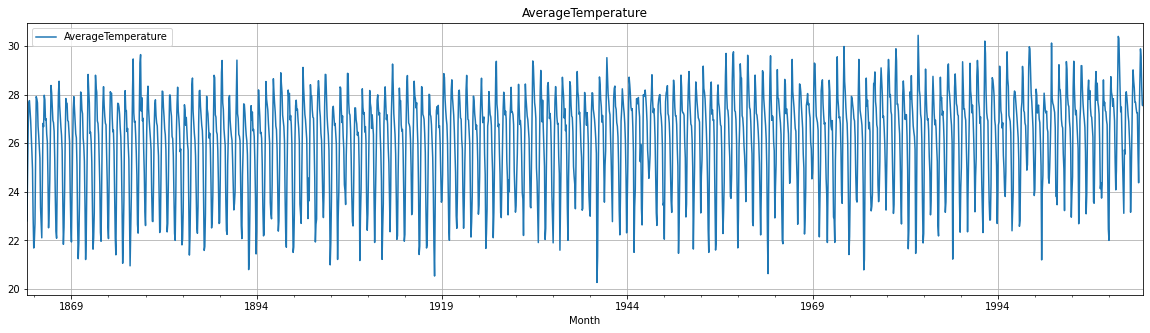

In [6]:
df1.plot(figsize=(20, 5))
plt.grid()
plt.legend(loc='best')
plt.title('AverageTemperature')
plt.show(block=False)

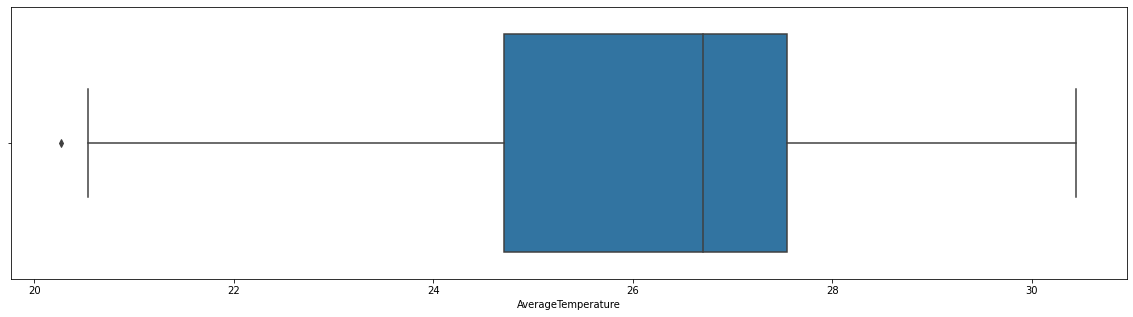

In [7]:
import seaborn as sns

fig = plt.subplots(figsize=(20, 5))
ax = sns.boxplot(x=df1['AverageTemperature'],whis=1.5)

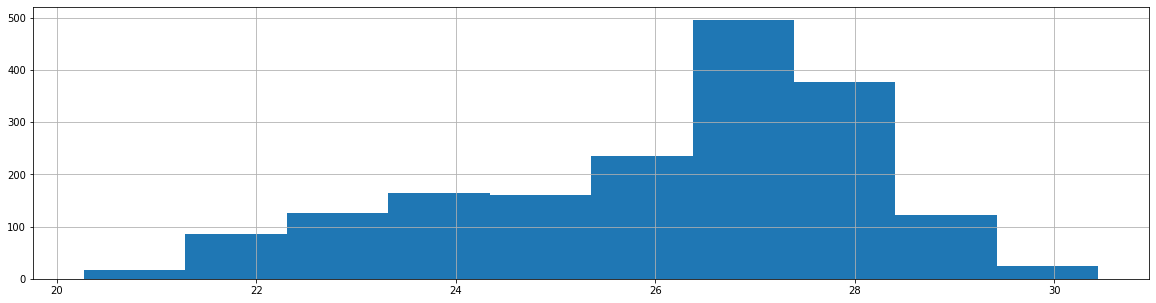

In [8]:
fig = df1.AverageTemperature.hist(figsize = (20,5))

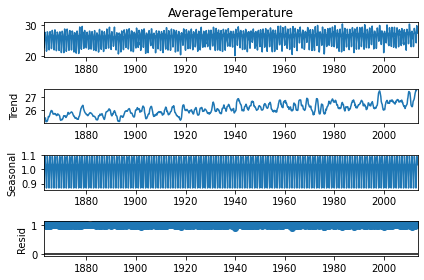

In [9]:
from pylab import rcParams
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df1.AverageTemperature, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

In [10]:
train_df = df1.iloc[:1446]
test_df = df1.iloc[1446:]
print('shapes:', df1.shape, train_df.shape, test_df.shape)

shapes: (1808, 1) (1446, 1) (362, 1)


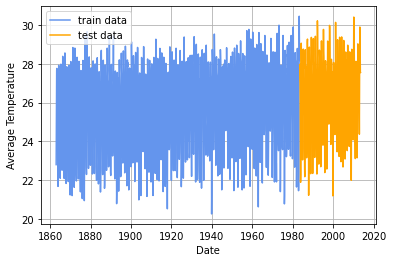

In [11]:
train_set_size = len(train_df)
train_set_dates = df1.head(train_set_size).index  # for plotting
test_set_dates = df1.tail(362).index  

plt.grid()
plt.plot(train_set_dates, train_df.AverageTemperature, color='cornflowerblue', label='train data')
plt.plot(test_set_dates, test_df.AverageTemperature, color='orange', label='test data')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.show()

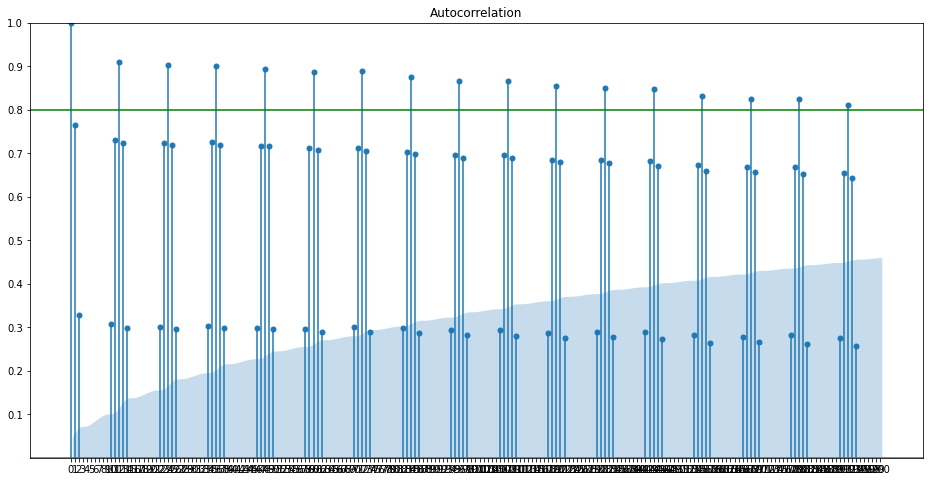

In [12]:
# find out which is the best lag to use
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

fig, ax = plt.subplots(figsize=(16,8))
plot_acf(df1['AverageTemperature'], lags=200, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(0, 201, 1))
plt.axhline(y=0.8, color="green")
plt.show()

In [13]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train_df, lags=192)
trained_model = model.fit()

C:\Users\Theethut\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

predictions = trained_model.predict(start=train_set_size, 
                                    end=train_set_size + 362 - 1)

error = mse(test_df, predictions)
error_mae = mae(test_df, predictions)

print(f'test MAE: {error_mae:}')
print(f'test MSE: {error:}')
print(f'test RMSE: {error ** 0.5:}')

test MAE: 0.5306742224310647
test MSE: 0.4900014186502349
test RMSE: 0.700001013320863


C:\Users\Theethut\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


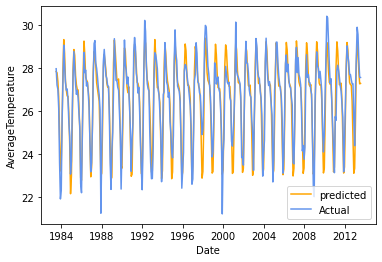

In [15]:
plt.plot(test_set_dates, predictions, color='orange', label='predicted')
plt.plot(test_df.index, test_df.AverageTemperature, color='cornflowerblue', 
         label='Actual')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('AverageTemperature')
plt.show()